In [ ]:
# Loading packages
from google.colab import drive
import os
from torchvision import transforms 
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import random
from tqdm.notebook import tqdm
import numpy as np

# Also, as we have a auxiliar python file with function, we go to use it
from cnn_functions import *

In [ ]:
# As our dataset is mounted in Google Drive, we need to get access to it.
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/DeepLearning/dataset/'
classes = os.listdir(data_dir)

Mounted at /content/drive


In [ ]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
# Checking the dataset training size
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 5400


In [ ]:
# Viewing one of images shape
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [ ]:
# Setting seed so that value won't change everytime
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(1)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
# Check the size of each dataset
len(train_ds), len(val_ds),len(test_ds)  

(4590, 270, 540)

In [ ]:
# Define batch size
batch_size = 12
# Define a generator of random values
g_cpu = torch.Generator()
g_cpu.manual_seed(123)
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True,generator  = g_cpu)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

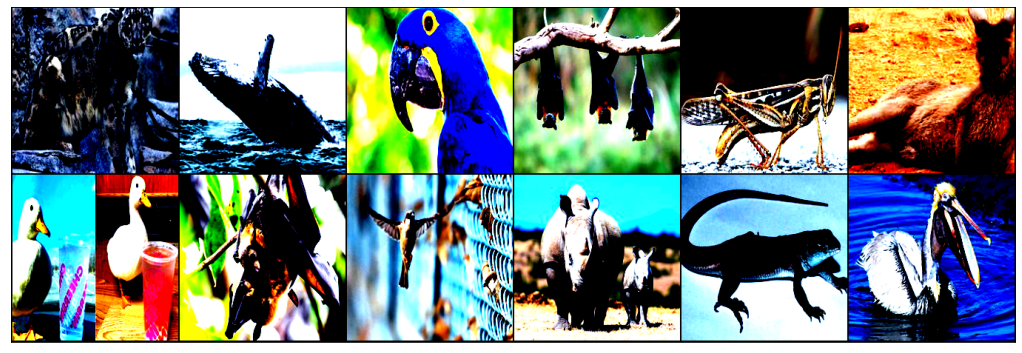

In [ ]:
# We can see some of these images available in one batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=6).permute(1, 2, 0))
    break

In [ ]:
# Now, we go to consider some parameters to start to create our models
input_size = torch.randn(1, 3, 224, 224)
output_size = 90

# Pass our data to GPU
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# **Create AlexNet Model**

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,kernel_size= 11, stride=4,padding=2)
        self.maxpool1 = nn.MaxPool2d(3,2)
        self.conv2 = nn.Conv2d(64,192,kernel_size=5,stride=1,padding=2)
        self.maxpool2 = nn.MaxPool2d(3,2)
        self.conv3 = nn.Conv2d(192,384,kernel_size=3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
        self.maxpool3 =nn.MaxPool2d(3,2)
        self.adaptavgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout1 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,self.num_classes)
        
    def forward(self,X):
        X = F.relu(self.conv1(X),inplace=True)
        X = self.maxpool1(X)
        X = F.relu(self.conv2(X),inplace=True)
        X = self.maxpool2(X)
        X = F.relu(self.conv3(X),inplace=True)
        X = F.relu(self.conv4(X),inplace=True)
        X = F.relu(self.conv5(X),inplace=True)
        X = self.maxpool3(X)
        X = self.adaptavgpool(X)
        X = torch.flatten(X, 1)
        X = self.dropout1(X)
        X = F.relu(self.fc1(X))
        X = self.dropout2(X)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [ ]:
# Reporting the Flops of this model
print_model_parm_flops(AlexNet(90),input_size, detail=False)

 + Number of FLOPs: 1.39G


# **AlexNet, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.01, epochs:20**

In [ ]:
cnn_sgd_lr001_performance = fit_model(AlexNet(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.504


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.489


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.464


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.499


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.494


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.450


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.413


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.346


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.301


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.225


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.183


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.138


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.096


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.011


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.984


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.917


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.859


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.871


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.821


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.813
Finished Training


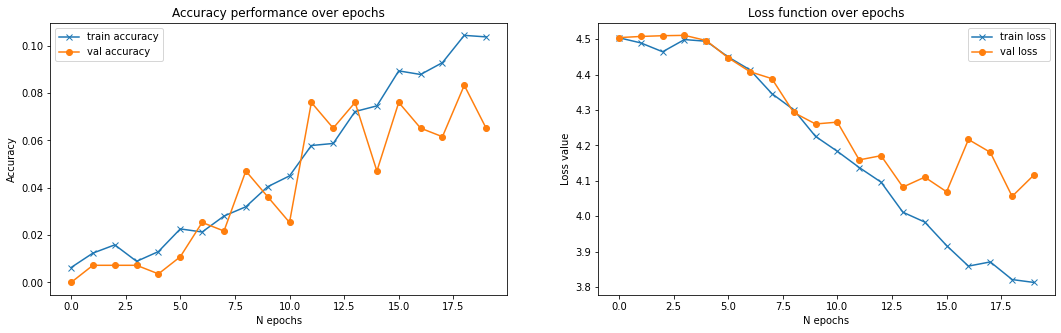

In [ ]:
# Plot results
plot_performance(cnn_sgd_lr001_performance[1],cnn_sgd_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.07222221791744232


# **AlexNet, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.001, epochs:20**

In [ ]:
cnn_sdg_lr01_performance = fit_model(AlexNet(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.499


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.498


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.497


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.493


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.470


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.424


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.383


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.310


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.181


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.068


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.938


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.856


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.736


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.623


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.541


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.426


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.330


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.234
Finished Training


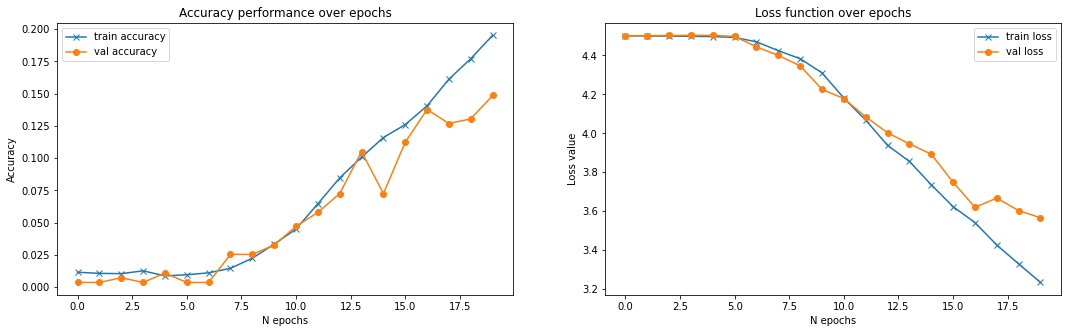

In [ ]:
# Plot results
plot_performance(cnn_sdg_lr01_performance[1],cnn_sdg_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sdg_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.1666666716337204


# **AlexNet, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.01, epochs:20**

In [ ]:
cnn_adam_lr001_performance = fit_model(AlexNet(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:9034.798


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:8.015


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.511


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510
Finished Training


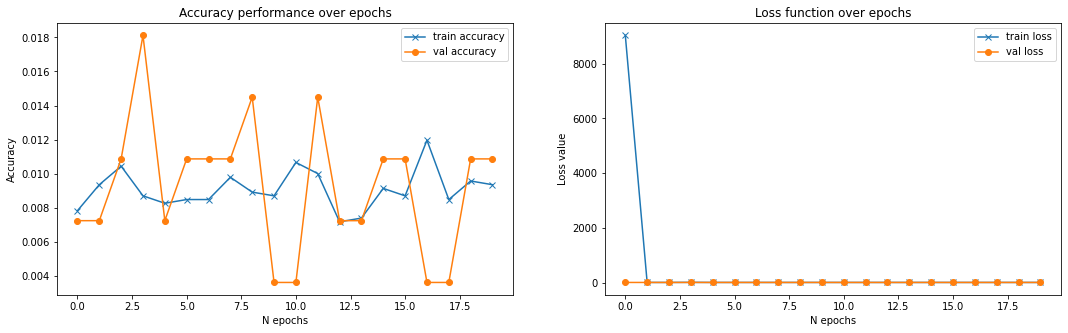

In [ ]:
# Plot results
plot_performance(cnn_adam_lr001_performance[1],cnn_adam_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.003703703870996833


# **AlexNet, Loss function: Cross entropy, Optimizer: ADAM, learning rate:0.001, epochs:20**

In [ ]:
cnn_adam_lr01_performance = fit_model(AlexNet(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.505


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.501


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.501


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500
Finished Training


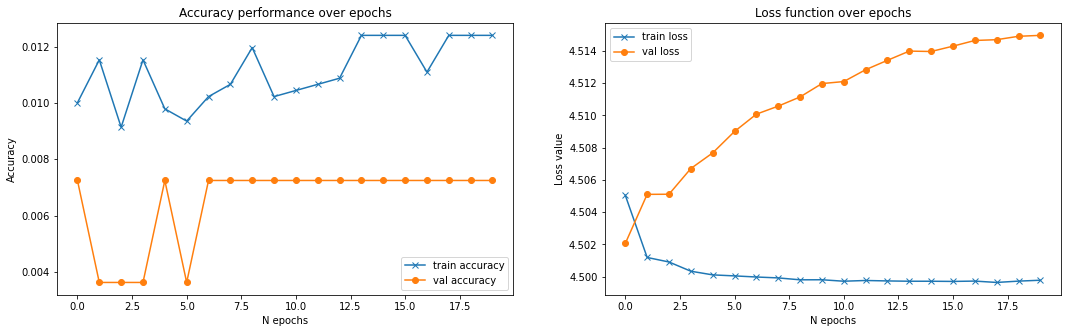

In [ ]:
# Plot results
plot_performance(cnn_adam_lr01_performance[1],cnn_adam_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.0018518519354984164


# **AlexNet pretrained Model**

In [ ]:
model_alex_pt = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alex_pt.classifier[4] = nn.Linear(4096,1024)
model_alex_pt.classifier[6] = nn.Linear(1024,90)
model_alex_pt.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# **AlexNet pretrained, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.01, epochs:20**

In [ ]:
cnn_sgd_lr001_performance = fit_model(model_alex_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.499


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.437


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.474


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.377


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.281


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.196


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.088


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.991


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.963


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.938


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.973


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.933


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.957


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.865


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.940


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.967


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.868


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.985


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.904


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.130
Finished Training


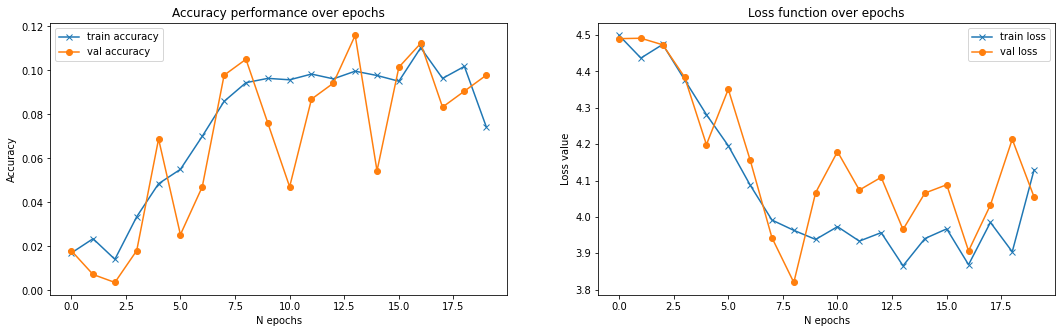

In [ ]:
# Plot results
plot_performance(cnn_sgd_lr001_performance[1],cnn_sgd_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.08148147165775299


# **AlexNet pretrained, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.001, epochs:20**

In [ ]:
model_alex_pt = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alex_pt.classifier[4] = nn.Linear(4096,1024)
model_alex_pt.classifier[6] = nn.Linear(1024,90)
model_alex_pt.eval()
cnn_sdg_lr01_performance = fit_model(model_alex_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.736


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.322


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.866


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.666


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.493


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.378


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.347


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.283


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.216


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.197


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.174


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.146


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.136


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.129


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.117


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.083


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.075


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.061


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.040


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.061
Finished Training


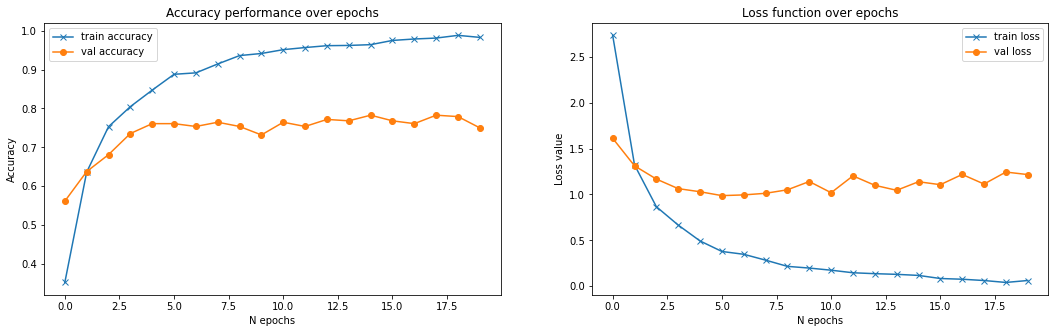

In [ ]:
# Plot results
plot_performance(cnn_sdg_lr01_performance[1],cnn_sdg_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sdg_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.7518517374992371


# **AlexNet pretrained, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.01, epochs:20**

In [ ]:
model_alex_pt = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alex_pt.classifier[4] = nn.Linear(4096,1024)
model_alex_pt.classifier[6] = nn.Linear(1024,90)
model_alex_pt.eval()
cnn_adam_lr001_performance = fit_model(model_alex_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:287.115


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:29.134


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.961


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:5.363


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.509
Finished Training


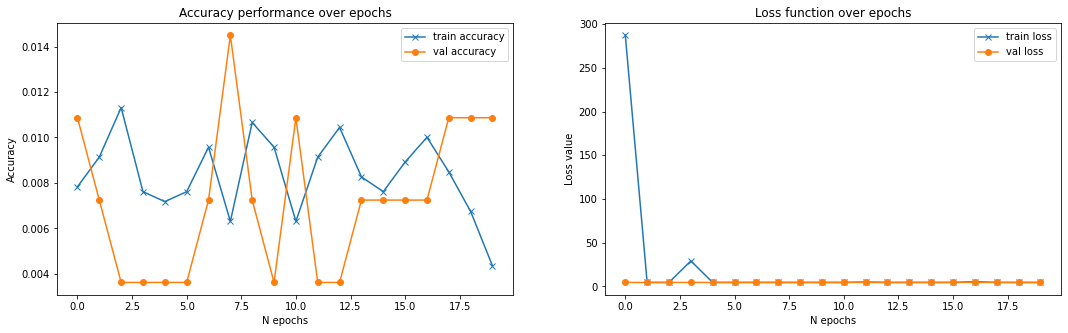

In [ ]:
# Plot results
plot_performance(cnn_adam_lr001_performance[1],cnn_adam_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.003703703870996833


# **AlexNet pretrained, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.001, epochs:20**

In [ ]:
model_alex_pt = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alex_pt.classifier[4] = nn.Linear(4096,1024)
model_alex_pt.classifier[6] = nn.Linear(1024,90)
model_alex_pt.eval()
cnn_adam_lr01_performance = fit_model(model_alex_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.510


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.501


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.501


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.501


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.501


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.500
Finished Training


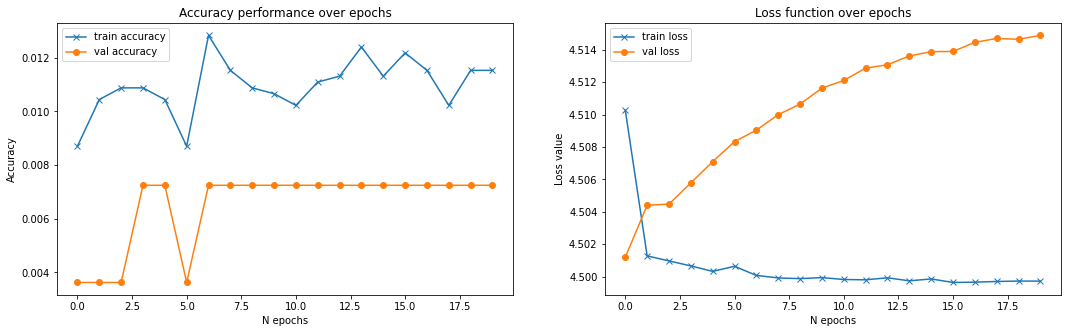

In [ ]:
# Plot results
plot_performance(cnn_adam_lr01_performance[1],cnn_adam_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.0018518519354984164
